In [1]:
import matplotlib
matplotlib.use('Agg')

import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

import h5py

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['font.size'] = '20'

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_67078/3957739208.py:22: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [2]:
import athena_read

In [3]:
vol_func = lambda rm,rp,thetam,thetap,phim,phip: \
            1.0/3.0*(rp**3-rm**3) * abs(np.cos(thetam)-np.cos(thetap)) * (phip-phim)
rarea_func = lambda r,thetam,thetap, phim, phip: \
           r**2.0 * abs(np.cos(thetam)-np.cos(thetap)) * (phip-phim)
tarea_func = lambda rm, rp, theta, phim, phip: \
          0.5*(rp**2.0 - rm**2.0)*np.sin(theta)*(phip - phim)
parea_func = lambda rm, rp, thetam, thetap: \
          0.5*(rp**2.0 - rm**2.0)*abs(thetap - thetam)

In [4]:
def PlotProfile2(data,sol,filename,ylabel1,ylabel2,label1=None,label2=None):
    plots, axes = plt.subplots(2,1,figsize=(9,11),dpi=300,sharex=True)
    plt.subplots_adjust(left=0.17,right=0.95,top=0.95,bottom=0.1,hspace=0.02)
    plt.xlabel('$ r $', size = 30)
    plt.xlim([0.4,10])
    
    nu_weight=sol[4]

    axes[0].plot(data[0],data[4][0,:],linewidth=4.0,color='blue',alpha=0.5,label=label1)
    axes[0].plot(data[0],data[4][1,:],linewidth=4.0,color='green',alpha=0.5,label='$E_{r,1}$')
    axes[0].plot(data[0],data[4][2,:],linewidth=4.0,color='orange',alpha=0.5,label='$E_{r,2}$')
    axes[0].plot(data[0],data[3]/data[1],linewidth=4.0,color='red',alpha=0.5,label=label2)
    axes[0].plot(sol[0],sol[1]*nu_weight[0],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[1]*nu_weight[1],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[1]*nu_weight[2],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[3]/sol[1],linewidth=2.0,color='black',linestyle='dashed')
#    axes[0].set_xscale('log')
    axes[0].set_ylabel(ylabel1, size=30)
    axes[0].set_ylim(2.e-5,1.5)  
    axes[0].set_yscale('log')  
    axes[0].yaxis.set_tick_params(labelsize=25)

    if label1 is not None:
        axes[0].legend(loc=[0.01,0.001],frameon=False,fontsize = 22)

#    axes[0].text(1.e-2, 2.3, '$a_rT_0^4/P_0=0.01$', dict(size=25,color='black'))
#    axes[0].text(1.e-2, 2.1, '$a_rT_0^4/P_0=1$', dict(size=25,color='blue'))
#    axes[0].text(1.e-2, 1.9, '$a_rT_0^4/P_0=10$', dict(size=25,color='red'))    


    axes[1].plot(data[0],data[5][0,:],linewidth=4.0,color='blue',alpha=0.5,label='$F_{r,0}$')
    axes[1].plot(data[0],data[5][1,:],linewidth=4.0,color='green',alpha=0.5,label='$F_{r,1}$')
    axes[1].plot(data[0],data[5][2,:],linewidth=4.0,color='orange',alpha=0.5,label='$F_{r,2}$')    
    axes[1].plot(sol[0],sol[2]*nu_weight[0],linewidth=2.0,color='black',linestyle='dashed')    
    axes[1].plot(sol[0],sol[2]*nu_weight[1],linewidth=2.0,color='black',linestyle='dashed')  
    axes[1].plot(sol[0],sol[2]*nu_weight[2],linewidth=2.0,color='black',linestyle='dashed')  
    
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set_ylabel(ylabel2, size=30)
    axes[1].set_ylim(1.e-6,0.7)    
    axes[1].yaxis.set_tick_params(labelsize=25)
    axes[1].xaxis.set_tick_params(labelsize=25)
    axes[1].legend(loc=[0.3,0.001],frameon=False,fontsize = 22)


    plt.savefig(filename)
    plt.clf()


In [5]:
def MakeImages(data, vx_cart, vy_cart, minval, maxval, vlim1, vlim2, xmin, xmax, ymin, ymax,
               xgrid,ygrid,label1,label2,time,outputname,vel=0,figtype=0,logscale=1,
               cmap='jet'):
    plots, axes = plt.subplots(2,1,figsize=(8,8),dpi=300, sharex=True)
    plt.subplots_adjust(left=0.13,right=0.82,top=0.98,bottom=0.05,hspace=0.0)


#    plt.xlabel('$ x$', size = 30)
#    plt.ylabel('$ y$', size = 30)      

    if time is not None:
        plt.title(time,size=30,y=1.02)

    
    if vel>0:
        speed=np.sqrt(vx_cart**2+vy_cart**2)
        if vlim2 < vlim1:
            vlim2=speed.max()
        speed=np.clip(speed,vlim1,vlim2)
        logspeed=np.log10(speed)
        vcolor=axes[0].imshow(speed,cmap=cmap,norm=LogNorm(vmin=vlim1,vmax=vlim2),
                              origin='lower', extent=[xmin,xmax,ymin,ymax])



        velfield=axes[0].streamplot(xgrid,ygrid,vx_cart,vy_cart,cmap='jet',
                                    density=0.5,arrowsize=3.0)
        
    if logscale > 0:
#      im = axes.imshow(data_cart,cmap='RdGy_r', norm=LogNorm(vmin = minval, vmax=maxval), 
        im = axes[0].imshow(data[0],cmap=cmap, norm=LogNorm(vmin = minval[0], vmax=maxval[0]),
                          origin='lower', extent=[xmin,xmax,ymin,ymax])
    else:
        im = axes[0].imshow(data[0],cmap=cmap, vmin = minval[0], vmax=maxval[0], 
                            origin='lower', extent=[xmin,xmax,ymin,ymax])   

    axes[0].set_yticks([0.3,0.2,0.1,0,-0.1,-0.2]) 
    axes[0].tick_params(labelsize=20)
#    axes[0].set_ylabel('$E_r$',size=30)

    cbaxes = plots.add_axes([0.83,0.55,0.03,0.35])

    cbar=plots.colorbar(im,cax=cbaxes)
    cbar.set_label(label1, size=30)
#    cbar.ax.set_yticklabels([0,100,200,300,400])
    cbar.ax.tick_params(labelsize=15)


    if logscale > 0:
#      im = axes.imshow(data_cart,cmap='RdGy_r', norm=LogNorm(vmin = minval, vmax=maxval), \
        im = axes[1].imshow(data[1],cmap=cmap, norm=LogNorm(vmin = minval[1], vmax=maxval[1]), 
                            origin='lower', extent=[xmin,xmax,ymin,ymax])
    else:
        im = axes[1].imshow(data[1],cmap=cmap, vmin = minval[1], vmax=maxval[1], 
                            origin='lower', extent=[xmin,xmax,ymin,ymax])   

    axes[1].set_yticks([0.3,0.2,0.1,0,-0.1,-0.2]) 
    axes[1].tick_params(labelsize=20)
#    axes[1].set_ylabel('$f_{xx}$',size=30)
    cbaxes = plots.add_axes([0.83,0.1,0.03,0.35])

    cbar=plots.colorbar(im,cax=cbaxes)
    cbar.set_label(label2, size=30)
#    cbar.ax.set_yticklabels([0,100,200,300,400])
    cbar.ax.tick_params(labelsize=15)


    
#    axes.set_aspect('auto')
    plt.savefig(outputname)
    plt.close(plots)



In [6]:
gamma=5.0/3.0
file1='beam.out4.00010.athdf'

with h5py.File(file1, 'r') as f:
  attributes = f.attrs.items()
  attrs = dict(attributes)
  level = f.attrs['MaxLevel']
  time1 = f.attrs['Time']
  subsample = False

  data1 = athena_read.athdf(file1,level=level, subsample=subsample)


In [7]:
nx1 = attrs['RootGridSize'][0] * 2**level
nx2 = attrs['RootGridSize'][1] * 2**level
nx3 = attrs['RootGridSize'][2] * 2**level
x1f = data1['x1f']
x2f = data1['x2f']
x3f = data1['x3f']
x1v = data1['x1v'] 
x2v = data1['x2v']
x3v = data1['x3v']
vol = np.zeros((nx3,nx2,nx1))


In [8]:
print(data1['VariableNames'])

[b'rho' b'press' b'vel1' b'vel2' b'vel3' b'Er' b'Fr1' b'Fr2' b'Fr3'
 b'Pr11' b'Pr22' b'Pr33' b'Pr12' b'Pr13' b'Pr23' b'Pr21' b'Pr31' b'Pr32'
 b'Er0' b'Fr01' b'Fr02' b'Fr03' b'Sigma_s' b'Sigma_a' b'Sigma_p']


In [9]:
er=data1['Er'][0,:,:]

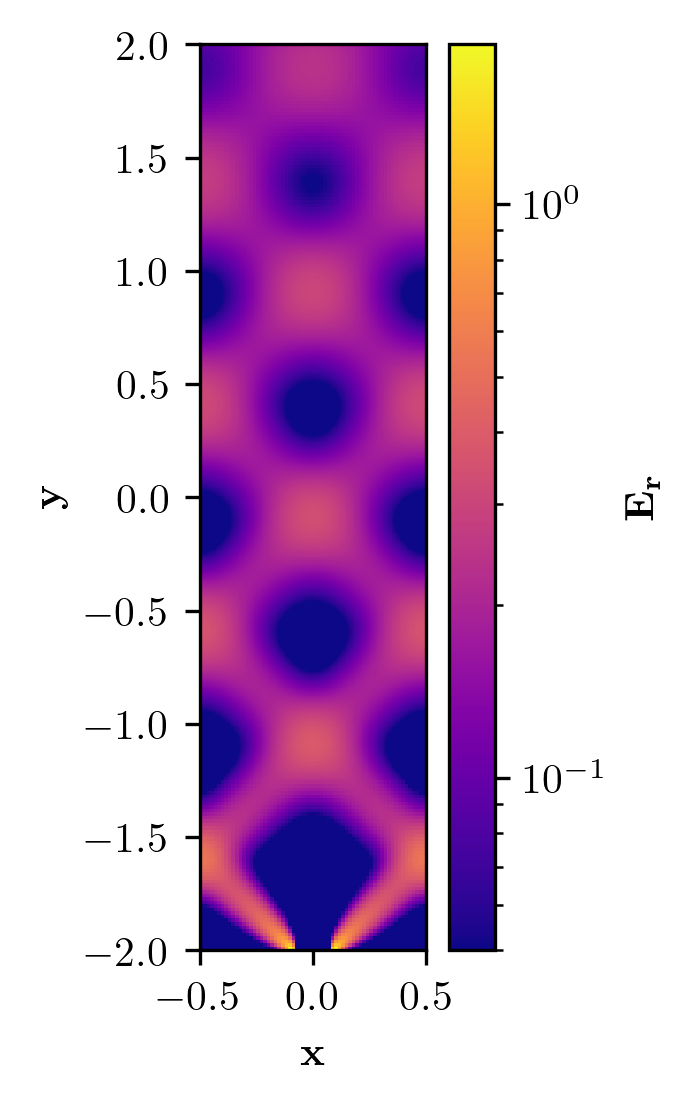

In [36]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(2,4),dpi=300)
im=axes.pcolormesh(x1f,x2f,er,norm=LogNorm(vmin=0.05, vmax=1.9),cmap='plasma')
axes.set_aspect('equal')
axes.set_xlabel(r'$\mathbf{x}$')
axes.set_ylabel(r'$\mathbf{y}$')
cbar=plots.colorbar(im, ax=axes)
cbar.set_label(r'$\mathbf{E_r}$')
plt.savefig('Er_beam.png')